## Determining Dataset count and visualization of Un/Balanced 

Counts of .wav files in each label folder:
Angry: 1016
Disgust: 1016
Fear: 1016
Happy: 1016
Neutral: 707
Sad: 1017
Surprise: 652


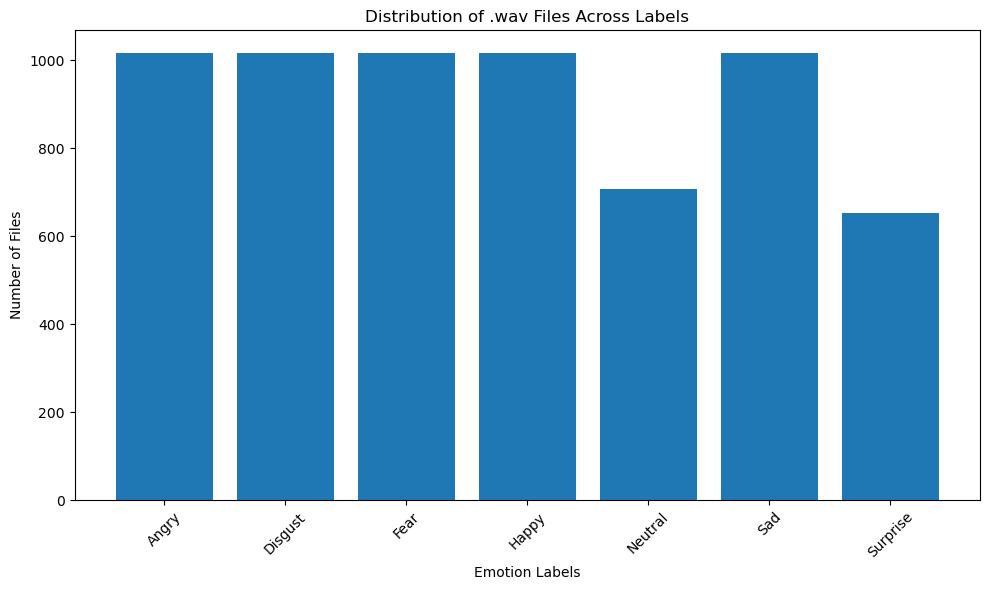

In [36]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Input folder containing labeled subfolders
input_folder = "../data"

# Initialize a counter for label counts
label_counts = Counter()

# Walk through the directory
for root, _, files in os.walk(input_folder):
    label = os.path.basename(root)  # Use the folder name as the label
    wav_count = sum(1 for file in files if file.endswith(".wav"))
    if wav_count > 0:  # Only count folders with .wav files
        label_counts[label] += wav_count

# Sort the labels alphabetically for better visualization
sorted_labels = sorted(label_counts.keys())
sorted_counts = [label_counts[label] for label in sorted_labels]

# Print counts
print("Counts of .wav files in each label folder:")
for label in sorted_labels:
    print(f"{label}: {label_counts[label]}")
    
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts)
plt.xlabel("Emotion Labels")
plt.ylabel("Number of Files")
plt.title("Distribution of .wav Files Across Labels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Most Labels Are Balanced, for unbalanced classes we will use ƛ (lambda) for the loss function 

- Labels  Angry, Disgust, Fear, Happy, and Sad are balanced
- Neutral has 707 files, which is ~30% fewer than the dominant classes.
- Surprise has 652 files, ~35% fewer than the dominant classes.

---

### Extracting Features from the audio 
- ### Converting the audio into numerical vector based off of MFCC, Chroma & Spectral Features
- ### Using the Librosa Library

## Code for the output and visualization of features

1016
1016
1016
1016
707
1017
652


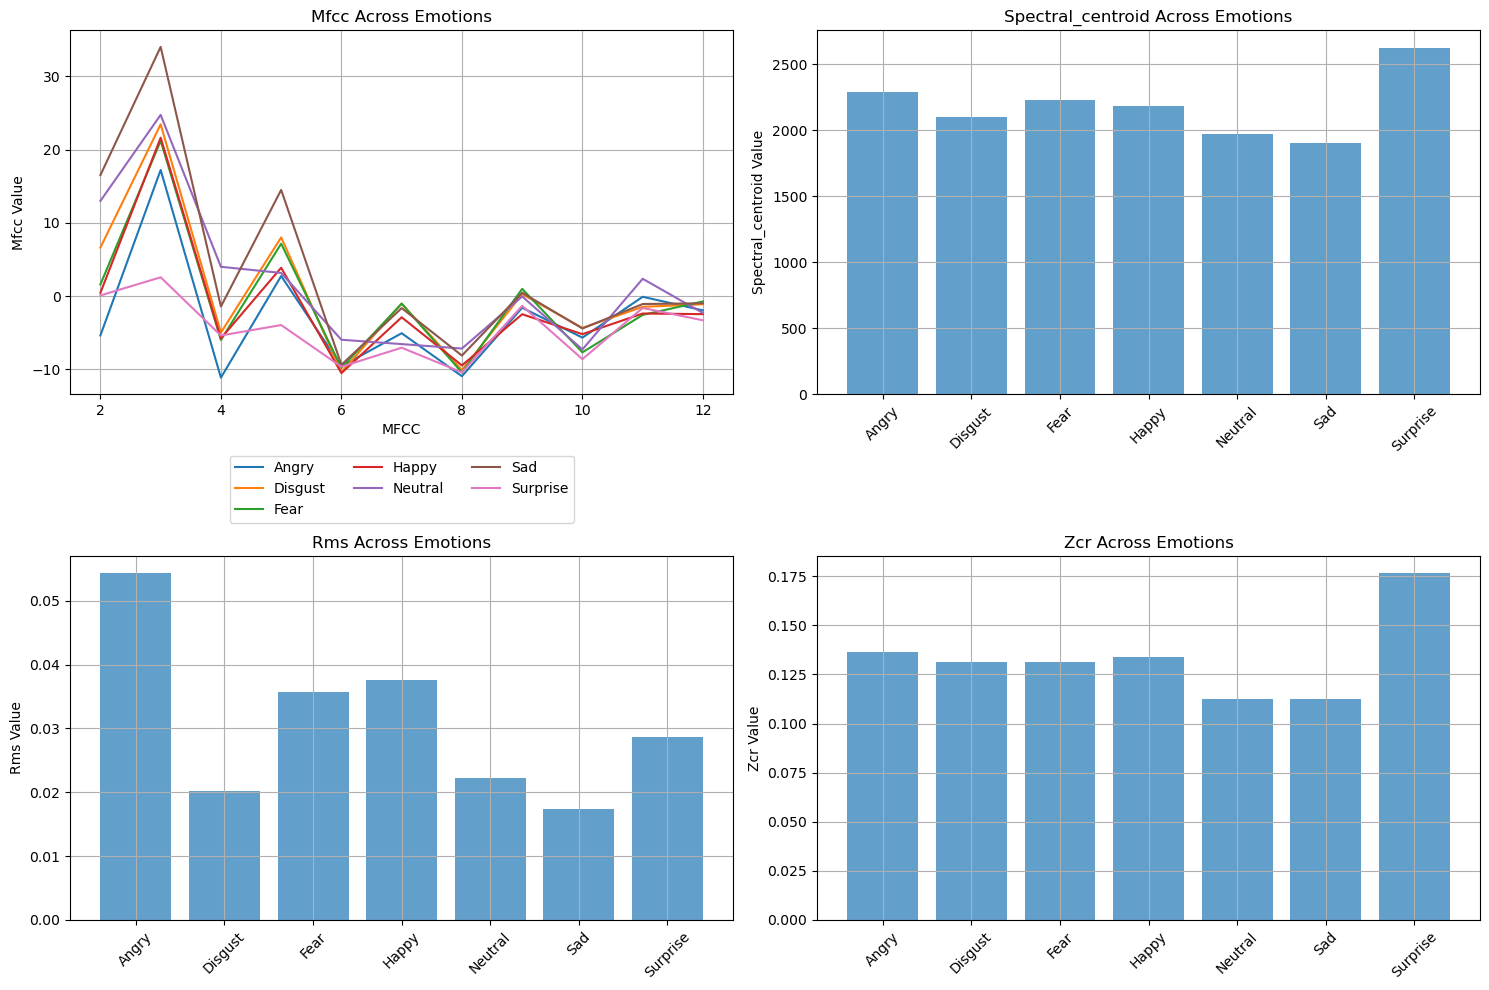

In [71]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt


# Function to extract features from a single file
def extract_emotion_features(file_path, sample_rate=22050):
    try:
        y, sr = librosa.load(file_path, sr=sample_rate)
        
        # Extract features
        features = {
            "mfcc": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1),
            "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            "spectral_bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            "rms": np.mean(librosa.feature.rms(y=y)),
            "zcr": np.mean(librosa.feature.zero_crossing_rate(y))
        }
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to process .wav files from a folder
def process_emotion_folder(folder_path):
    features_list = []
    count = 0
    try:
        # Filter only .wav files 
        wav_files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]
        
        for file in wav_files:
            file_path = os.path.join(folder_path, file)
            count += 1
            features = extract_emotion_features(file_path)
            if features:
                features_list.append(features)
    except Exception as e:
        print(f"Error reading folder {folder_path}: {e}")
    
    print(count)
    return features_list

# Function to average features for a set of files
def average_features(features_list):
    avg_features = {}
    for key in features_list[0].keys():
        values = [features[key] for features in features_list if features]
        if isinstance(values[0], np.ndarray):  # For array-like features (e.g., MFCCs)
            avg_features[key] = np.mean(np.vstack(values), axis=0)
        else:  # For scalar features
            avg_features[key] = np.mean(values)
    return avg_features

# Function to visualize features across emotions
def visualize_emotions(emotion_folders):
    avg_features_by_emotion = {}
    
    # Process and average features for each emotion
    for emotion, folder in emotion_folders.items():
        features_list = process_emotion_folder(folder)  
        if features_list:
            avg_features = average_features(features_list)
            avg_features_by_emotion[emotion] = avg_features

    # Prepare subplots for different features
    features_to_plot = ["mfcc", "spectral_centroid", "rms", "zcr"]
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, 2, i)
        
        if feature == "mfcc":
            # Plot MFCC averages across coefficients 
            for emotion, avg_features in avg_features_by_emotion.items():
                mfccs = avg_features[feature]
                plt.plot(range(2, len(mfccs)), mfccs[2:], label=emotion) 
            plt.xlabel("MFCC")
            plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
        else:
            # Plot single-valued features (e.g., RMS, ZCR)
            emotions = list(avg_features_by_emotion.keys())
            values = [avg_features_by_emotion[emotion][feature] for emotion in emotions]
            plt.bar(emotions, values, alpha=0.7)
            plt.xticks(rotation=45)

        plt.title(f"{feature.capitalize()} Across Emotions")
        plt.ylabel(f"{feature.capitalize()} Value")
        plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage
emotion_folders = {
    "Angry": "../data/Angry/",
    "Disgust": "../data/Disgust/",
    "Fear": "../data/Fear/",
    "Happy": "../data/Happy/",
    "Neutral": "../data/Neutral/",
    "Sad": "../data/Sad/",
    "Surprise": "../data/Surprise/"
}

visualize_emotions(emotion_folders)


Top Left: MFCC (Mel-Frequency Cepstral Coefficients)
- MFCCs are derived from the spectral properties of the audio, capturing the timbre of the voice.
- Peaks and valleys in MFCC values indicate variations in speech timbre for different emotions.

Top Right: Spectral Centroid
- Shows the "brightness" of the audio, representing the average frequency at which most energy is concentrated.
- Higher centroid values indicate more high-frequency content, likely caused by higher pitch or sharp tones. Lower centroid values correspond to softer, lower-pitched speech.

Bottom Left: RMS (Root Mean Square Energy)
- Shows the average loudness or energy of the audio for each emotion.
    - Angry and Happy have the highest energy levels, consistent with their dynamic and loud expressions.
    - Disgust and Sad have the lowest energy levels, correlating with their softer and quieter tones.

Bottom Right: ZCR (Zero-Crossing Rate)
- Shows the rate at which the audio signal crosses zero amplitude, measuring noisiness or percussiveness.
    - Surprise has the highest ZCR, suggesting noisier or more abrupt transitions in the speech signal.

## Code for Parrallel Processing the entire dataset

In [78]:
import librosa
import numpy as np
import os
import pandas as pd

# Function to extract features from a single file
def extract_emotion_features(file_path, sample_rate=22050):
    try:
        print(f"Processing file: {file_path}")
        y, sr = librosa.load(file_path, sr=sample_rate)

        features = {
            "mfcc": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1),
            "rms": np.mean(librosa.feature.rms(y=y)),
            "pitch": np.mean(librosa.piptrack(y=y, sr=sr), axis=1)[0],
            "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            "spectral_bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            "spectral_rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            "zcr": np.mean(librosa.feature.zero_crossing_rate(y))
        }

        # Flatten features into a fixed-length vector
        feature_vector = []
        for value in features.values():
            if isinstance(value, np.ndarray):
                feature_vector.extend(value)
            else:
                feature_vector.append(value)

        return feature_vector
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to process all files in label folders
def process_label_folders(label_folders, output_csv, sample_rate=22050):
    audio_files = []
    labels = []

    # Collect all .wav files from label folders
    for label, folder_path in label_folders.items():
        folder_files = [
            os.path.join(root, file)
            for root, _, files in os.walk(folder_path)
            for file in files if file.endswith(".wav")
        ]
        audio_files.extend(folder_files)
        labels.extend([label] * len(folder_files))  # Assign labels to files

    feature_list = []
    file_labels = []

    # Process each file sequentially
    for i, file_path in enumerate(audio_files):
        print(f"Processing file {i + 1}/{len(audio_files)}: {file_path}")
        features = extract_emotion_features(file_path)
        if features is not None:
            feature_list.append(features)
            file_labels.append(labels[i])

    # Ensure all feature vectors have the same length by padding with None (null in CSV)
    max_length = max(len(f) for f in feature_list)
    feature_list = [f + [None] * (max_length - len(f)) for f in feature_list]

    # Create a DataFrame with features and labels only
    df = pd.DataFrame(feature_list)
    df['label'] = file_labels
    df = df[['label'] + [col for col in df.columns if col != 'label']]  # Reorder label as the first column

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Feature extraction complete! Data saved to {output_csv}")

if __name__ == "__main__":
    # Define the label folders
    label_folders = {
        "Angry": "../data/Angry/",
        "Disgust": "../data/Disgust/",
        "Fear": "../data/Fear/",
        "Happy": "../data/Happy/",
        "Neutral": "../data/Neutral/",
        "Sad": "../data/Sad/",
        "Surprise": "../data/Surprise/"
    }

    # Output CSV path
    output_csv = "emotion_features.csv"

    # Process all files in label folders
    process_label_folders(label_folders, output_csv)


Processing file 1/6440: ../data/Angry/03-01-05-01-02-01-16.wav
Processing file: ../data/Angry/03-01-05-01-02-01-16.wav
Processing file 2/6440: ../data/Angry/03-01-05-01-02-01-02.wav
Processing file: ../data/Angry/03-01-05-01-02-01-02.wav
Processing file 3/6440: ../data/Angry/OAF_king_angry.wav
Processing file: ../data/Angry/OAF_king_angry.wav
Processing file 4/6440: ../data/Angry/OAF_rot_angry.wav
Processing file: ../data/Angry/OAF_rot_angry.wav
Processing file 5/6440: ../data/Angry/OAF_hire_angry.wav
Processing file: ../data/Angry/OAF_hire_angry.wav
Processing file 6/6440: ../data/Angry/03-01-05-02-01-01-02.wav
Processing file: ../data/Angry/03-01-05-02-01-01-02.wav
Processing file 7/6440: ../data/Angry/03-01-05-02-01-01-16.wav
Processing file: ../data/Angry/03-01-05-02-01-01-16.wav
Processing file 8/6440: ../data/Angry/03-01-05-01-01-01-22.wav
Processing file: ../data/Angry/03-01-05-01-01-01-22.wav
Processing file 9/6440: ../data/Angry/a04$.wav
Processing file: ../data/Angry/a04$.wav

## Tips for Better Performance in training
- Normalize Features: Scale features to a uniform range (e.g., 0–1 or standardize with mean=0, variance=1).
- Reduce Dimensionality: Use PCA or feature selection methods to focus on the most relevant features.
- Use Class-Specific Weights: Address imbalances in emotional class distribution.